Given a pair of images I want to stitch them to create a panoramic scene. 

Note, one fundamental requirement is that both images need to share some common regions.

Also, the solution need to work even if the pictures have different Scaling or Angle (Perspective) or Spacial position or Capturing devices.

### What is Image Stitching

A technique of combining several overlapping images from
the similar viewpoint into a bigger one without thrashing of
information is known as an image stitching. The most
universally used methods are the Harris corner detection
method and the Scale Invariant Feature Transform (SIFT)
method.


### Image Matching 

Features matching or generally Image Matching, a part of many computer vision applications such as image registration, camera calibration and object recognition, is the task of establishing correspondences between two images of the same scene/object. 

A common approach to image matching consists of detecting a set of interest points - each associated with **image descriptors** from the individual image data. Once the features and their descriptors have been extracted from two or more images, the next step is to establish some preliminary feature matches between these images.


![Imgur](https://imgur.com/XzsXL5T.png)




### Feature Descriptor

A feature descriptor is an algorithm which takes an image and outputs locations (i.e. pixel coordinates) of significant areas in your image. An example of this is a corner detector, which outputs the locations of corners in your image but does not tell you any other information about the features detected.  The **"location"** might also include a number describing the size or scale of the feature. This is because things that look like corners when "zoomed in" may not look like corners when "zoomed out", and so specifying scale information is important. So instead of just using an (x,y) pair as a location in "image space", you might have a triple (x,y,scale) as location in "scale space".

Feature descriptors encode interesting information into a series of numbers and act as a sort of numerical “fingerprint” that can be used to differentiate one feature from another.


Ideally, this information would be invariant under image transformation, so we can find the feature again even if the image is transformed in some way. After detecting interest point we go on to compute a descriptor for every one of them. Descriptors can be categorized into two classes:

**Local Descriptor**: It is a compact representation of a point’s local neighborhood. Local descriptors try to resemble shape and appearance only in a local neighborhood around a point and thus are very suitable for representing it in terms of matching.

**Global Descriptor:** A global descriptor describes the whole image. They are generally not very robust as a change in part of the image may cause it to fail as it will affect the resulting descriptor.


#### Main Feature Descriptor Algorithms

* SIFT(Scale Invariant Feature Transform)
* SURF(Speeded Up Robust Feature)
* BRISK (Binary Robust Invariant Scalable Keypoints)
* BRIEF (Binary Robust Independent Elementary Features)
* ORB(Oriented FAST and Rotated BRIEF)


Methods like SIFT and SURF try to address the limitations of corner detection algorithms. Usually, corner detector algorithms use a fixed size kernel to detect regions of interest (corners) on images. It is easy to see that when we scale an image, this kernel might become too small or too big.

To address this limitation, methods like SIFT uses Difference of Gaussians (DoG). The idea is to apply DoG on differently scaled versions of the same image. It also uses the neighboring pixel information to find and refine key points and corresponding descriptors.


"When you have two identical images, except one is scaled differently than the other, SIFT maximizes the Difference of Gaussians (DoG) in scale and in space to find same key points independently in each image. DoG is basically the difference of the Gaussian blurring of an image with different standard deviation. Every octave, or scale, of the image is blurred with Gaussians with standard deviations of different scaling factors. The differences between adjacent Gaussian-blurred images are calculated as DoG. The process is repeated for each octave of scaled image."

![Imgur](https://imgur.com/9FOpV1N.png)

[Source](https://ai.stanford.edu/~syyeung/cvweb/tutorial2.html)


### SIFT vs Harris Corner Detection for Image Matching


1. The Harris Detector, is rotation-invariant, which means that the detector can still distinguish the corners even if the image is rotated. However, the Harris Detector cannot perform well if the image is scaled differently.

2. Due to the characteristics of SIFT, the key point descriptors are constructed to extract features by finding the precise positioning and main directions of feature points, in different scale spaces. 

The key points extracted by SIFT have scale invariance and rotation.




In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
cv2.ocl.setUseOpenCL(False)
import warnings
warnings.filterwarnings('ignore')

In [18]:
feature_extraction_algo = 'sift'
feature_to_match = 'bf'

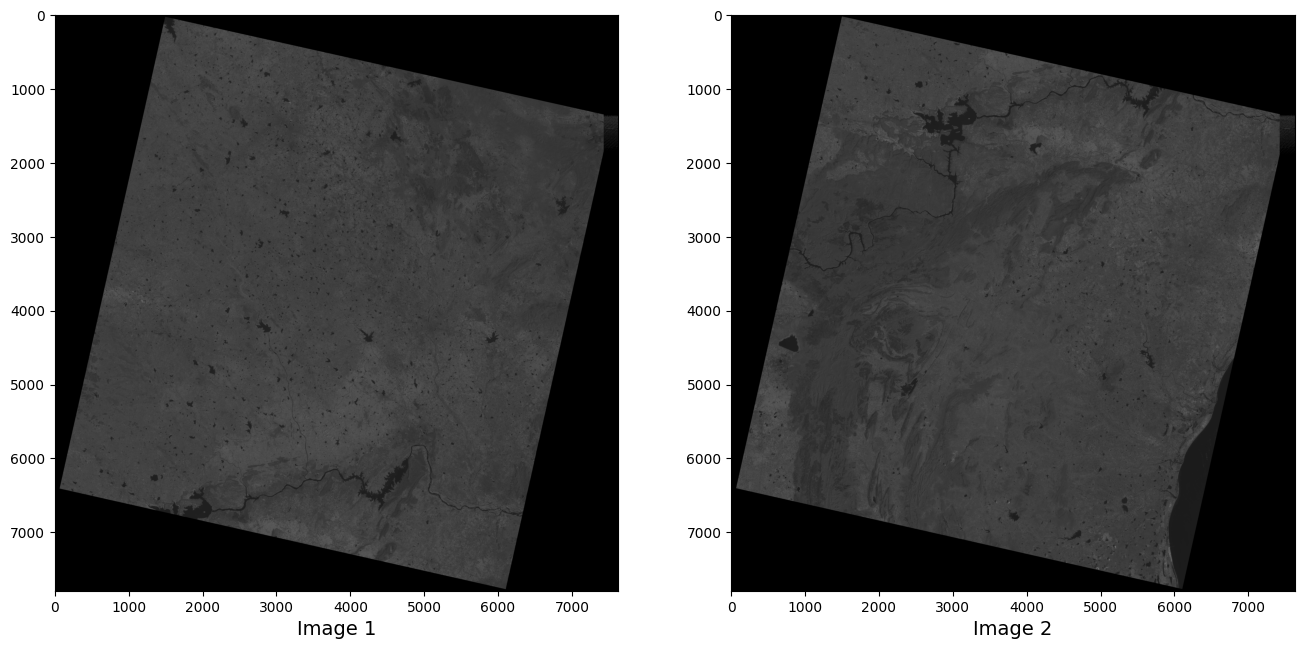

In [19]:
# Make sure that the train image is the image that will be transformed
train_photo = cv2.imread(r"C:\Users\pgsar\Desktop\LC08_L2SP_143049_20230301_20230315_02_T1_SR_B5.TIF")

# OpenCV defines the color channel in the order BGR 
# Hence converting to RGB for Matplotlib
train_photo = cv2.cvtColor(train_photo,cv2.COLOR_BGR2RGB)

# converting to grayscale
train_photo_gray = cv2.cvtColor(train_photo, cv2.COLOR_RGB2GRAY)

# Do the same for the query image 
query_photo = cv2.imread(r"C:\Users\pgsar\Desktop\LC08_L2SP_143048_20230301_20230315_02_T1_SR_B5 (1).TIF")
query_photo = cv2.cvtColor(query_photo,cv2.COLOR_BGR2RGB)
query_photo_gray = cv2.cvtColor(query_photo, cv2.COLOR_RGB2GRAY)

# Now view/plot the images
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(query_photo, cmap="gray")
ax1.set_xlabel("Image 1", fontsize=14)

ax2.imshow(train_photo, cmap="gray")
ax2.set_xlabel("Image 2", fontsize=14)


plt.show()

#### Get Keypoints and Descriptors. 

For example SIFT is both rotation as well as scale invariant.  SIFT provides key points and keypoint descriptors where keypoint descriptor describes the keypoint at a selected scale and rotation with image gradients.
Directly find [keypoints and descriptors](https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html) in a single step with the function, `sift.detectAndCompute()`.

#### What does sift.detectAndCompute() return

```py
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(gray,None)

```

### In above `keypoints` will be a list of keypoints and `descriptors` is a numpy array of shape (Number of Keypoints)×128


### Why do we use keypoint descriptors?

Very good explanation from [here](https://dsp.stackexchange.com/questions/10423/why-do-we-use-keypoint-descriptors)


One important thing to understand is that after extracting the keypoints, you only obtain information about their position, and sometimes their coverage area (usually approximated by a circle or ellipse) in the image. While the information about keypoint position might sometimes be useful, it does not say much about the keypoints themselves.

Depending on the algorithm used to extract keypoint (SIFT, Harris corners, MSER), you will know some general characteristics of the extracted keypoints (e.g. they are centered around blobs, edges, prominent corners...) but you will not know how different or similar one keypoint is to the other.

Here's two simple examples where only the position and keypoint area will not help us:

- If you have an image A (of a bear on a white background), and another image B, exact copy of A but translated for a few pixels: the extracted keypoints will be the same (on the same part of that bear). Those two images should be recognized as same, or similar.

But, if the only information we have is their position, and that changed because of the translation, you can not compare the images.

- If you have an image A (let's say, of a duck this time), and another image B, exactly the same duck as in A except twice the size: the extracted keypoints will be the same (same parts of the duck). Those are also same (similar) images.

But all their sizes (areas) will be different: all the keypoints from the image B will be twice the size of those from image A.

So, **here come descriptors:** they are the way to compare the keypoints. They summarize, in vector format (of constant length) some characteristics about the keypoints. For example, it could be their intensity in the direction of their most pronounced orientation. It's assigning a numerical description to the area of the image the keypoint refers to.

Some important things for descriptors are:

- **they should be independent of keypoint position**

If the same keypoint is extracted at different positions (e.g. because of translation) the descriptor should be the same.

- **they should be robust against image transformations**

Some examples are changes of contrast (e.g. image of the same place during a sunny and cloudy day) and changes of perspective (image of a building from center-right and center-left, we would still like to recognize it as a same building).

Of course, no descriptor is completely robust against all transformations (nor against any single one if it is strong, e.g. big change in perspective).

Different descriptors are designed to be robust against different transformations which is sometimes opposed to the speed it takes to calculate them.

- **they should be scale independent**

The descriptors should take scale in to account. If the "prominent" part of the one keypoint is a vertical line of 10px (inside a circular area with radius of 8px), and the prominent part of another a vertical line of 5px (inside a circular area with radius of 4px) -- these keypoints should be assigned similar descriptors.


---


SURF (Speeded-Up Robust Features)

Even though SIFT works well it performs intensive operations which are time consuming. SURF was introduced to have all the advantages of SIFT with reduced processing time.

ORB

ORB is an efficient open source alternative to SIFT and SURF. Even though it computes less key points when compared to SIFT and SURF yet they are effective. It uses FAST and BRIEF techniques to detect the key points and compute the image descriptors respectively.

In [20]:


def select_descriptor_methods(image, method=None):    
    
    assert method is not None, "Please define a feature descriptor method. accepted Values are: 'sift', 'surf'"
    
    if method == 'sift':
        descriptor = cv2.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    (keypoints, features) = descriptor.detectAndCompute(image, None)
    
    return (keypoints, features)

In [21]:
keypoints_train_img, features_train_img = select_descriptor_methods(train_photo_gray, method=feature_extraction_algo)

keypoints_query_img, features_query_img = select_descriptor_methods(query_photo_gray, method=feature_extraction_algo)

Making sense of the Keypoints array returned from above function

![Imgur](https://imgur.com/XT7FTPV.png)

Apart from octave and class_id parameters, which have integer values, the other arguments have float values.

Read further [here](https://docs.opencv.org/3.4/d2/d29/classcv_1_1KeyPoint.html)

#### Lets check what keypoint consist of

---

In [22]:
for keypoint in keypoints_query_img:
    x,y = keypoint.pt
    size = keypoint.size 
    orientation = keypoint.angle
    response = keypoint.response 
    octave = keypoint.octave
    class_id = keypoint.class_id


print (x,y)
 
print(size)

print(orientation)

print(response)
print(octave)
print(class_id)

7627.8955078125 1420.4097900390625
1.8880659341812134
96.44732666015625
0.030516669154167175
3604991
-1


#### Earlier I mentioned `descriptors` is a numpy array of shape (Number of Keypoints)×128

Lets verify that

In [23]:
print(len(keypoints_query_img))

features_query_img.shape

12033


(12033, 128)

We run detectAndCompute() on both, the query and the train image. At this point, we have a set of key points and descriptors for both images. If we use SIFT as the feature extractor, it returns a 128-dimensional feature vector for each key point. If SURF is chosen, we get a 64-dimensional feature vector. 

---

### From where the value of 128 is coming in sift descriptor ?

First the workflow of SIFT is like this - that  running SIFT on an image will return many keypoints, each of which has an associated descriptor/vector describing the region around that point.

![Imgur](https://imgur.com/pxMSiPp.png)

When keypoint descriptor is created - A 16x16 neighbourhood around the keypoint is taken. It is divided into 16 sub-blocks of 4x4 size. For each sub-block, 8 bin orientation histogram is created. 

So a total of 128 bin ( 4 * 4 * 8) values are available. It is represented as a vector to form keypoint descriptor. 

So again in SIFT, the 128 dimensional feature vector is made up of **4x4 samples per window in 8 directions per sample** -- 4x4x8 = 128.

For an illustrated guide see [A Short introduction to descriptors](https://gilscvblog.com/2013/08/18/a-short-introduction-to-descriptors/), and in particular this image, showing 8-direction measurements (cardinal and inter-cardinal) embedded in each of the 4x4 grid squares (center image) and then a histogram of directions (right image):

[![enter image description here][1]][1]

#### And thats how, the descriptors are K-by-128 matrix, where each row is a descriptor for one of the K keypoints. The descriptor is a vector of 128 values normalized to unit length.

#### Noting a basic fact that - SIFT descriptor is computed for every key-point detected in the image. Before computing descriptor, you probably used a detector (as Harris, Sift or Surf Detector) to detect points of interest. Detecting key-points and computing descriptors are two independent steps!

And on what the information inside the descriptor *is* -- it is called Histograms of Oriented Gradients (HOG). For further reading, Wikipedia has an overview of HOG [gradient computation](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients#Gradient_computation):

> Each pixel within the cell casts a weighted vote for an orientation-based histogram channel based on the values found in the gradient computation.

Everything is built on those per-pixel "votes".

  [1]: https://i.stack.imgur.com/OTZDW.jpg

---

Below images are produced with `cv2.drawKeypoints()` and presents some of the features extracted using SIFT, SURF, BRISK, and ORB.

[source](https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html)


#### Syntax to define `drawKeypoints()` function in OpenCV:

`drawKeypoints(input_image, keypoints, output_image, color, flag)`

Where,

* input_image is the image from which the key points are derived using SIFT or SURF algorithm.
* keypoints are the key points derived from the input image using SIFT or SURF algorithm.
* output_image is the image on which key points are drawn in circles.
* color represents the color of the key points drawn in circles.
* flag represents the drawing features.


### Working of drawKeypoints() Function in OpenCV

The distinct features in a given image that makes the image stand out are called key points in a given image. Key points of a given image assists us in object detection of comparison of images. There are several algorithms to detect key points in a given image. In order to be able to draw the detected keypoints on a given image, we make use of a function called drawKeypoints() function in OpenCV. The drawKeypoints() function takes the input image, keypoints, color and flag as the input.

The possible values for flag are:

* cv.DRAW_MATCHES_FLAGS_DEFAULT
* cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
* cv.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG
* cv.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS

The keypoints drawn using `drawKeypoints()` function are special because even if we rotate the images or shrink the images or expand the images or translate the images or distort the images the keypoints remain the same in the modified image when compared to the original image. The keypoints are scale invariant and are circular. The drawKeypoints() function returns an image with keypoints drawn on the image.



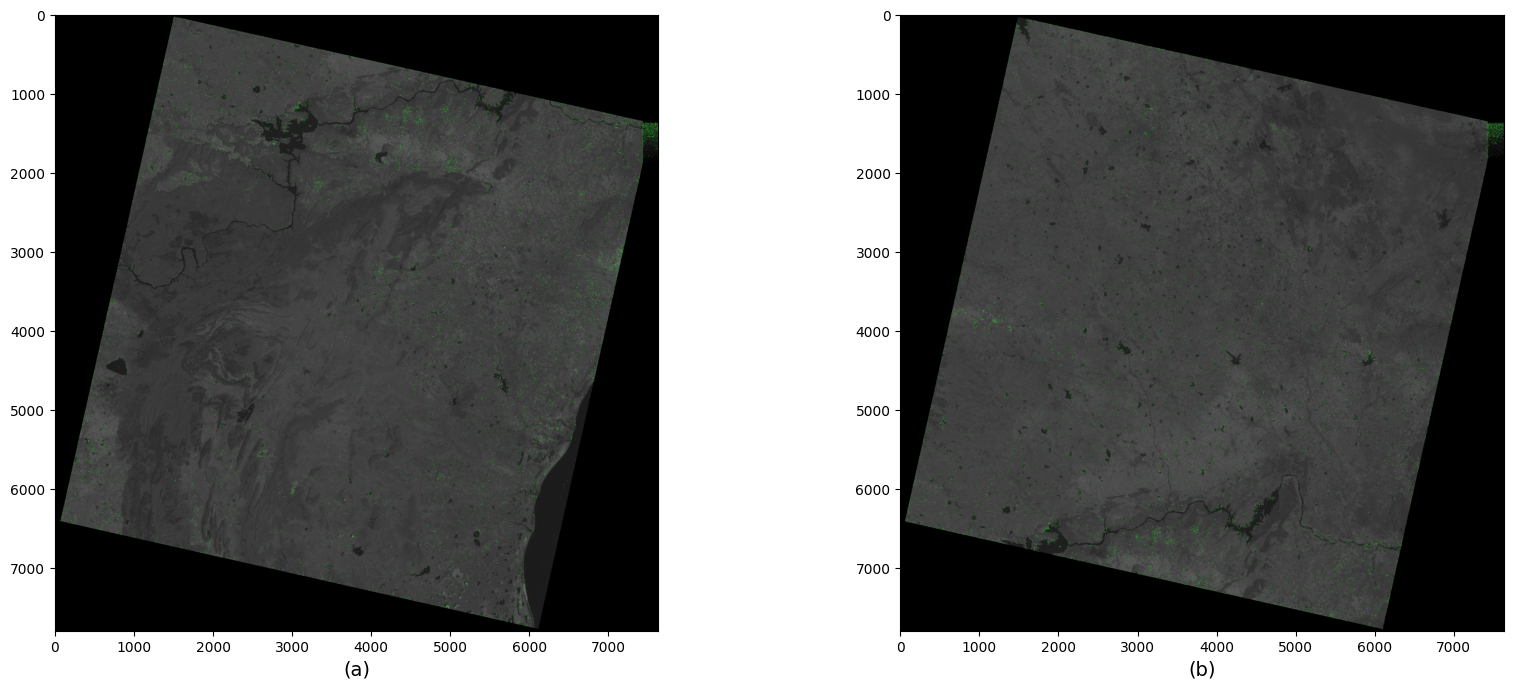

In [24]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)

ax1.imshow(cv2.drawKeypoints(train_photo_gray, keypoints_train_img, None, color=(0,255,0)))

ax1.set_xlabel("(a)", fontsize=14)

ax2.imshow(cv2.drawKeypoints(query_photo_gray,keypoints_query_img,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

 
plt.show()

#### What is constrained_layout

[From Official Doc](https://matplotlib.org/stable/tutorials/intermediate/constrainedlayout_guide.html)

Constrained layout attempts to resize subplots in a figure so that there are no overlaps between axes objects and labels on the axes.

constrained_layout automatically adjusts subplots and decorations like legends and colorbars so that they fit in the figure window while still preserving, as best they can, the logical layout requested by the user.

constrained_layout is similar to tight_layout, but uses a constraint solver to determine the size of axes that allows them to fit.

constrained_layout needs to be activated before any axes are added to a figure. 

Currently Constrained Layout is experimental. The behaviour and API are subject to change, or the whole functionality may be removed without a deprecation period. If you require your plots to be absolutely reproducible, get the Axes positions after running Constrained Layout and use ax.set_position() in your code with constrained_layout=False.

#### bbox_inches='tight'

tight_layout automatically adjusts subplot params so that the subplot(s) fits in to the figure area. This is an experimental feature and may not work for some cases. It only checks the extents of ticklabels, axis labels, and titles.

If the axis labels in the plot are cut off in the saved image, set bbox_inches='tight'.

---

### [Basics of Brute-Force Matcher](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html)


BF Matcher matches the descriptor of a feature from one image with all other features of another image and returns the match based on some distance calculation. So in another words, given 2 sets of features (from image 1 and image 2), each feature from set 1 is compared against all features from set 2. It is slow since it checks match with all the features.

It is a simple technique to decide which feature in the query image is best matched with that in the train image. This perfect match is elected looking at the smallest distance among those computed among one feature in the train pic and all the features in the query pic.

Brute-Force matcher is simple. It takes the descriptor of one feature in first set and is matched with all other features in second set using some distance calculation. And the closest one is returned.

For BF matcher, first we have to create the BFMatcher object using cv2.BFMatcher(). It takes two optional params. 

First one is **normType.** It specifies the distance measurement to be used. By default, it is **cv2.NORM_L2**. It is good for SIFT, SURF etc (cv2.NORM_L1 is also there). 

For binary string based descriptors like ORB (Oriented FAST and Rotated BRIEF), BRIEF(Binary Robust Independent Elementary Features), BRISK etc, **cv2.NORM_HAMMING** should be used, which used Hamming distance as measurement. If ORB is using VTA_K == 3 or 4, cv2.NORM_HAMMING2 should be used. 

Second param is boolean variable, **crossCheck** which is false by default. It indicates whether the two features have to match each other to be considered valid.

If it is true, Matcher returns only those matches with value (i,j) such that i-th descriptor in set A has j-th descriptor in set B as the best match and vice-versa. That is, the two features in both sets should match each other. It provides consistant result, and is a good alternative to ratio test proposed by D.Lowe in SIFT paper. 

This crossChecking procedure ensures a more robust set of matching features and is described in the original SIFT paper.

Once it is created, two important methods are BFMatcher.match() and BFMatcher.knnMatch(). First one returns the best match. Second method returns k best matches where k is specified by the user. It may be useful when we need to do additional work on that.


### Ratio Testing vs crossChecking

To make sure the features returned by KNN are well comparable, the authors of the SIFT paper, suggests a technique called ratio test. Basically, we iterate over each of the pairs returned by KNN and perform a distance test. For each pair of features (f1, f2), if the distance between f1 and f2 is within a certain ratio, we keep it, otherwise, we throw it away. Also, the ratio value must be chosen manually.
In essence, ratio testing does the same job as the cross-checking option from the BruteForce Matcher. Both, ensure a pair of detected features are indeed close enough to be considered similar. 

---

### Why Hamming Distance for ORB Descriptors

First re-visit the definitions of those 2 distances

#### Definition of Hamming Distance

Hamming distance is a metric for comparing two binary data strings. While comparing two binary strings of equal length, Hamming distance is the number of bit positions in which the two bits are different. 
Example - Suppose there are two strings 1101 1001 and 1001 1101.

11011001 ⊕ 10011101 = 01000100. Since, this contains two 1s, the Hamming distance, d(11011001, 10011101) = 2.


#### Definition of Euclidian Distance

When comparing descriptors in computer vision, the Euclidian distance is usually understood as the square root of the sum of the squared differences between the two vectors' elements.

![Imgur](https://imgur.com/GInpClP.png)

Hamming should be more efficient (in term of computation) to use the HAMMING distance rather than the L1/L2 distance as the HAMMING distance can be implemented using a XOR followed by a bit count. Of course, with a classical descriptor like SIFT, you cannot use the HAMMING distance.


The ORB descriptors are vectors of binary values. If applying Euclidian distance to binary vectors, the squared result of a single comparison would always be 1 or 0, which is not informative when it comes to estimating the difference between the elements. The overall Euclidian distance would be the square root of the sum of those ones and zeroes, again not a good estimator of the difference between the vectors.

That's why the Hamming distance is used. Here the distance is the number of elements that are not the same. You can calculate it by a simple boolean operation on the vectors, as shown in the figure below. Here D1 is a single 4-bit descriptor that we are comparing with 4 descriptors shown in D2. Matrix H is the hamming distances for each row.

[Source](https://stackoverflow.com/a/62152880)

[![A quick illustration of Hamming distance calculation in CV.][1]][1]


  [1]: https://i.stack.imgur.com/M103e.png

### Feature Matching

In [25]:
def create_matching_object(method,crossCheck):
    "Create and return a Matcher Object"
    
    # For BF matcher, first we have to create the BFMatcher object using cv2.BFMatcher(). 
    # It takes two optional params. 
    # normType - It specifies the distance measurement
    # crossCheck - which is false by default. If it is true, Matcher returns only those matches 
    # with value (i,j) such that i-th descriptor in set A has j-th descriptor in set B as the best match 
    # and vice-versa. 
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

### Two important approaches `BFMatcher.match()` and `BFMatcher.knnMatch()`, the first returns the best match, the second method returns k best matches.

So it feels that knnMatch gives more choices, and the candidate points are more likely to contain real matching points. In other words, **knnMatch** returns the n-best matches in descriptor2 for each descriptor in descriptor1. 

**Which means, instead of a list of matches you get a list of a list of matches.**

The main advantage using **knnMatch** is that you can perform a ratio test. So if the distances from one descriptor in descriptor1 to the two best descriptors in descriptor2 are similar it suggests that there are repetitive patterns in your images (e.g. the tips of a picket fence in front of grass). Thus, such matches aren't reliable and should be removed.

In [26]:
def key_points_matching(features_train_img, features_query_img, method):
    bf = create_matching_object(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(features_train_img,features_query_img)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches with Brute force):", len(rawMatches))
    return rawMatches

### Now I will use `BFMatcher.knnMatch()` to get k best matches.

For cases where we want to consider more than one candidate match, we can use a KNN based matching procedure.
Instead of returning the single best match for a given feature, KNN returns the k best matches.
Note that the value of k has to be pre-defined by the user. As we expect, KNN provides a larger set of candidate features. However, we need to ensure that all these matching pairs are robust before going further.

In [27]:
def key_points_matching_KNN(features_train_img, features_query_img, ratio, method):
    bf = create_matching_object(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(features_train_img, features_query_img, k=2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

#### [From Docs](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html)

Like we used `cv2.drawKeypoints()` to draw keypoints, `cv2.drawMatches()` helps us to draw the matches. It stacks two images horizontally and draw lines from first image to second image showing best matches. There is also `cv2.drawMatchesKnn` which draws all the k best matches. If k=2, it will draw two match-lines for each keypoint. So we have to pass a mask if we want to selectively draw it.


`cv2.drawMatches` => Draws the found matches of keypoints from two images.

Parameters of `cv2.drawMatches`

* img1	First source image.

* keypoints1	Keypoints from the first source image.

* img2	Second source image.

* keypoints2	Keypoints from the second source image.

* matches1to2	Matches from the first image to the second one, which means that keypoints1[i] has a corresponding point in keypoints2[matches[i]] 

* outImg	Output image. Its content depends on the flags value defining what is drawn in the output image. See possible flags bit values below.

* flags: NOT_DRAW_SINGLE_POINTS means Single keypoints will not be drawn.

Drawing: bf matched features Lines
Raw matches with Brute force): 4239


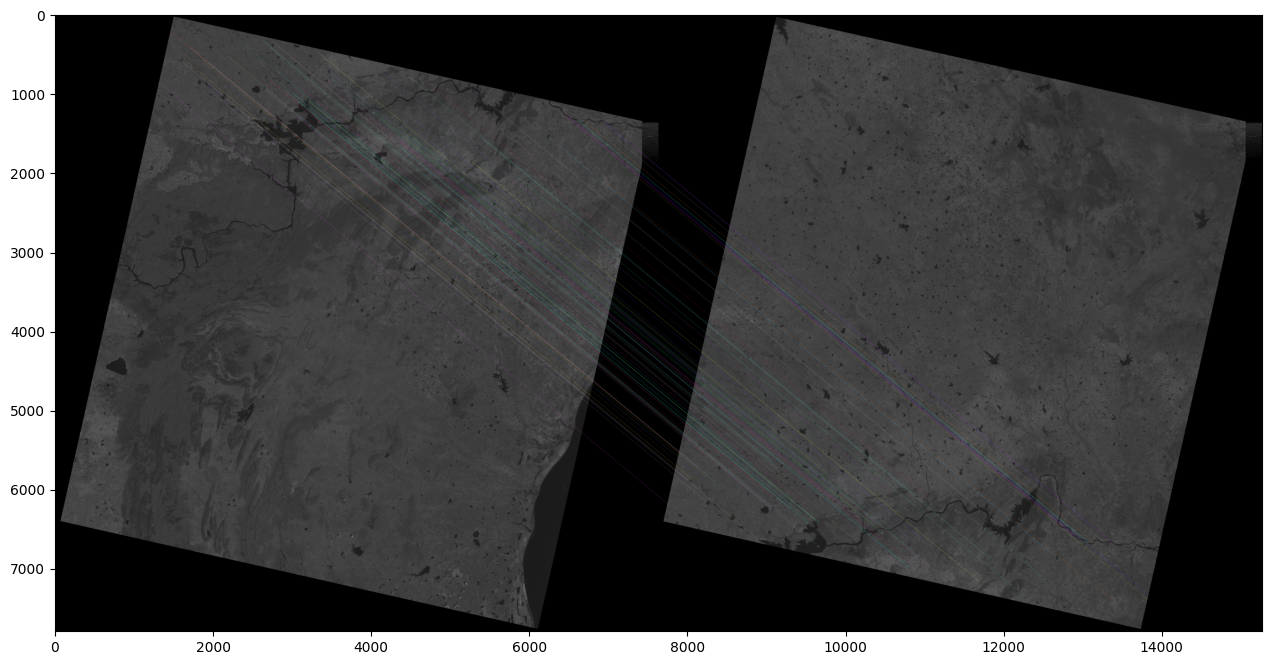

In [28]:
print("Drawing: {} matched features Lines".format(feature_to_match))

fig = plt.figure(figsize=(20,8))

if feature_to_match == 'bf':
    matches = key_points_matching(features_train_img, features_query_img, method=feature_extraction_algo)
    
    mapped_features_image = cv2.drawMatches(train_photo,keypoints_train_img,query_photo,keypoints_query_img,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Now for cross checking draw the feature-mapping lines also with KNN
elif feature_to_match == 'knn':
    matches = key_points_matching_KNN(features_train_img, features_query_img, ratio=0.75, method=feature_extraction_algo)
    
    mapped_features_image_knn = cv2.drawMatches(train_photo, keypoints_train_img, query_photo, keypoints_query_img, np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(mapped_features_image)
# plt.axis('off')
# plt.savefig("./output/" + feature_to_match + "_matching_img_"+'.jpeg', bbox_inches='tight', 
#             dpi=300, optimize=True, format='jpeg')
# plt.show()

#### Now running the same above code to produce the mapped features with 'knn'

Drawing: knn matched features Lines
Raw matches (knn): 12629


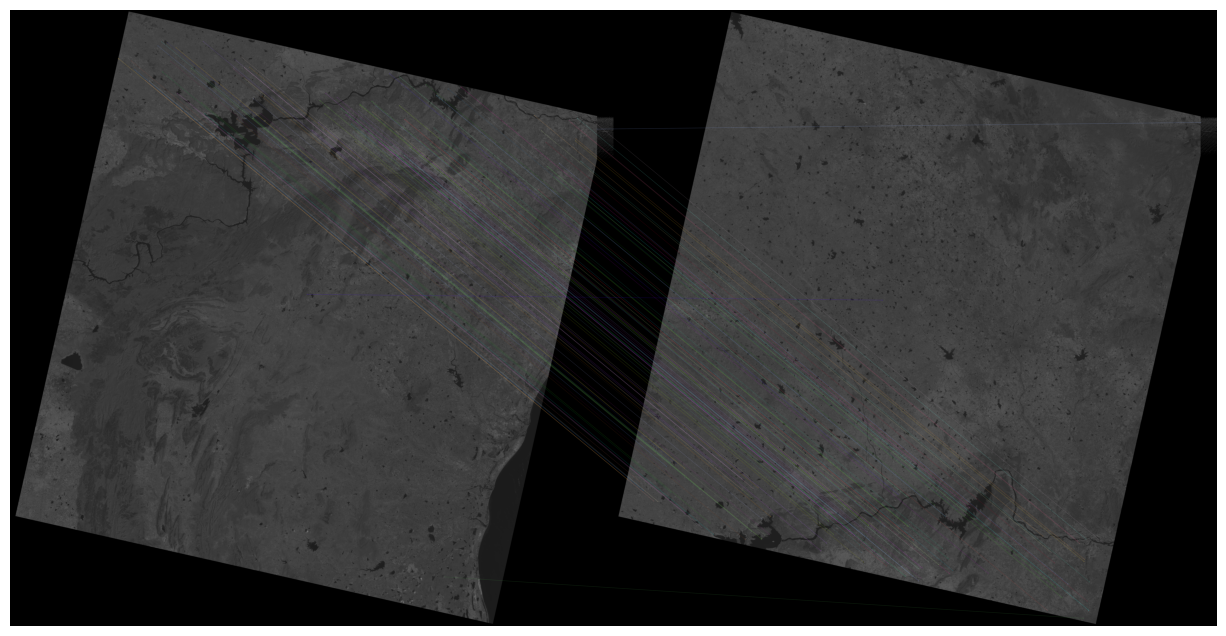

In [29]:
feature_to_match = 'knn'

print("Drawing: {} matched features Lines".format(feature_to_match))

fig = plt.figure(figsize=(20,8))

if feature_to_match == 'bf':
    matches = key_points_matching(features_train_img, features_query_img, method=feature_extraction_algo)
    
    mapped_features_image = cv2.drawMatches(train_photo,keypoints_train_img,query_photo,keypoints_query_img,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Now for cross checking draw the feature-mapping lines also with KNN
elif feature_to_match == 'knn':
    matches = key_points_matching_KNN(features_train_img, features_query_img, ratio=0.75, method=feature_extraction_algo)
    
    mapped_features_image_knn = cv2.drawMatches(train_photo, keypoints_train_img, query_photo, keypoints_query_img, np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(mapped_features_image_knn)
plt.axis('off')

plt.show()

We can see that after cross-checking for Brute force and Ratio test in KNN, some of the features do not match properly.

---

### Why Homography matrix is needed in Image stitching for creating Panorama ?

**What is Homography ?** - Homography is a transformation that maps the points in one point to the corresponding point in another image. The homography is a 3×3 matrix :

![Imgur](https://imgur.com/Eb4SP3f.png)


It is easy to understand homography once we are able to visualise what we are trying to do when we aim to stitch the different images together. Imagine 2 scenarios.

- (1) — Take a step to the left each time you capture a photo, while holding the camera still.

- (2) — Standing on a fixed position, you rotate your body while holding a camera and capture the different photos while you rotate.

If we want to stitch the images together in (1), we can simply overlay a photo on top of another in the sequence and have a good result. However in (2), if we want to stitch the images together by simply overlaying the images on top of one another in sequence, we will realise that the result of the stitching is bad (regions will be missed out due to the different planes of the captured images). As such, we will need homography to project an image onto the same plane of the other image before stitching them together.
Next, you can think of homography as basically a matrix — a matrix that transform points from an image to another image of the same plane. So the next question is how do we solve for the homography matrix H?

---

The homography matrix is a 3x3 matrix but with 8 DoF (degrees of freedom),

A homography is a perspective transformation of a plane, that is, a reprojection of a plane from one camera into a different camera view, subject to change in the translation (position) and rotation (orientation) of the camera.

Perspective transformations map 3-D points onto 2-D image planes using the transformation matrix that incorporates the camera characteristics: focal length, optical centre, and the extrinsic parameters (rotation, translation) .

So again fundamentally Homography matrix is a mapping between two planes. We have considered it here as a mapping from the image plane to a physical plane, but it could map between two image planes. A homography is a type of projective transformation in that we take advantage of projections to relate two images. Homographies were originally introduced to study shifts in perspective, and they have enabled people to better understand how images change when we look at them from a different perspective.


### What is Homography in the context of 2 images ?

#### Below Great [Explanation is from here](https://learnopencv.com/homography-examples-using-opencv-python-c/)


Consider two images of a plane (top of the book) shown in Figure 1. The red dot represents the same physical point in the two images. In computer vision jargon we call these corresponding points. Figure 1. shows four corresponding points in four different colors — red, green, yellow and orange. A Homography is a transformation ( a 3×3 matrix ) that maps the points in one image to the corresponding points in the other image.

![Imgur](https://imgur.com/eHYT1br.png)

![Imgur](https://imgur.com/AOxEhcp.png)


The above equation is true for ALL sets of corresponding points as long as they lie on the same plane in the real world. In other words you can apply the homography to the first image and the book in the first image will get aligned with the book in the second image!

---

#### Homography Matrix in more simple terms for 2 Imags

Homography matrix simply represents the transformation of one point in an image plane to the same point in another image plane.

### $$X1 = H * X2$$


The point X1 is the same point (X2) in a different plane.

So the H matrix is basically the description of how one point in, lets say, image 1 matches 1 point in image2. The 3x3 homography matrix computes the transformation between sets of 2D points between two spaces

#### How to calculate a Homography?

To calculate the homography between two images, we must know at least four corresponding points between them. OpenCV robustly estimates a homography that fits all corresponding points in the best possible way. The point correspondences are found by matching features like SIFT or SURF between the images.

**The RANSAC algorithm (RANdom SAmple Consensus) is used to estimate a Homography. It computes a homography and gives you a prediction for which pairs are inliers and which are outliers.**

---


### [`cv2.findHomography()`](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#findhomography)

This function Finds a perspective transformation between two planes. If we pass the set of points from both the images, it will find the perspective transformation of that object.


![Imgur](https://imgur.com/bTUBvz7.png)

The method RANSAC can handle practically any ratio of outliers but it needs a threshold to distinguish inliers from outliers. The method LMeDS does not need any threshold but it works correctly only when there are more than 50% of inliers. Finally, if there are no outliers and the noise is rather small, use the default method (method=0).

---


#### RANdom SAmple Consensus or RANSAC 

RANdom SAmple Consensus or RANSAC is an iterative algorithm to fit linear models. Different from other linear regressors, RANSAC is designed to be robust to outliers. Here, I will use RANSAC to estimate the Homography matrix. Noting Homography is very sensitive to the quality of data we pass to it, hence need an algorithm (RANSAC) that can filter irrelevant points from the data distribution.

---

### How is RANSAC used to estimate a homography given the descriptors of both images computed with SIFT?


In SIFT, we first generate keypoints and the feature vector for each keypoint. Also, if k is a keypoint in image x and k′ is a keypoint in image x′, the feature vectors give a way to tell whether k,k′ are good matches. For each k, we look for a good match: a k′ from x′ that is significantly closer to k than any other keypoint in x′. The set of good matches forms a set of possible inliers.

Then, we apply RANSAC. We randomly pick four good matches, compute a homography from these four, and test how good this homography is by checking how many of the good matches are consistent with the homography (if k,k′ are a good match, we're hoping that in most cases the homography will map k to something near k′). Good matches that are consistent with the homography are called inliers (for this homography), and those that aren't are called outliers (for this homography). We count the number of outliers for this homography. Then, we repeat this 1000 times (picking a set of four good matches anew each time), in each iteration deriving a homography and counting the number of outliers associated with it. We keep the homography with the smallest number of outliers.

![Imgur](https://imgur.com/dwyUviE.png)



In [30]:
def homography_stitching(keypoints_train_img, keypoints_query_img, matches, reprojThresh):
    """ converting the keypoints to numpy arrays before passing them for calculating Homography Matrix.
    
    Because we are supposed to pass 2 arrays of coordinates to cv2.findHomography, as in I have these points in image-1, and I have points in image-2, so now what is the homography matrix to transform the points from image 1 to image 2
    """
    keypoints_train_img = np.float32([keypoint.pt for keypoint in keypoints_train_img])
    keypoints_query_img = np.float32([keypoint.pt for keypoint in keypoints_query_img])
    
    ''' For findHomography() - I need to have an assumption of a minimum of correspondence points that are present between the 2 images. Here, I am assuming that Minimum Match Count to be 4 '''
    if len(matches) > 4:
        # construct the two sets of points
        points_train = np.float32([keypoints_train_img[m.queryIdx] for m in matches])
        points_query = np.float32([keypoints_query_img[m.trainIdx] for m in matches])
        
        # Calculate the homography between the sets of points
        (H, status) = cv2.findHomography(points_train, points_query, cv2.RANSAC, reprojThresh)

        return (matches, H, status)
    else:
        return None

#### Note on the [ransacReprojThreshold][1] argument in the `findHomography`

Official docs describes inliers vs outliers:

[![enter image description here][2]][2]

For 1), RANSAC computes the error (vector norm) between the observed projection, `dstPoint_i`, and the projection of `srcPoint_i` computed with a candidate homography, `H`. Then it just does a simple threshold check. The user can set the **ransacReprojThreshold** to whatever value you find that works best for your data. If you're in pixel coordinates, you just set the maximum error in pixel distance for a point to be considered an inlier. Anything with greater error is considered an outlier.

For 2), the RANSAC algorithm will simply choose the H matrix that maximizes the number of inliers based on the threshold you set. So the mask it returns to you is the set with the greatest number of inliers.

[Here's the source][3], if you're interested.


  [1]: https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#findhomography
  [2]: https://i.stack.imgur.com/D7o3S.png
  [3]: https://github.com/opencv/opencv/blob/4c86fc13cb8f272ac750ea03c90e6c9d8a855384/modules/calib3d/src/ptsetreg.cpp#L76

In [31]:
M = homography_stitching(keypoints_train_img, keypoints_query_img, matches, reprojThresh=4)

if M is None:
    print("Error!")

(matches, Homography_Matrix, status) = M

print(Homography_Matrix)

[[ 9.99998026e-01 -7.69413042e-06 -1.20000060e+03]
 [-3.08511902e-05  1.00002040e+00  5.32006896e+03]
 [-1.58647903e-09  2.60280814e-09  1.00000000e+00]]


The above "Homography_Matrix" is basically the description of how one point in, lets say, image 1 matches 1 point in image2.

#### After Homography Matrix calculation, need to warp one of the images to a common plane


Finally, we can apply our transformation by calling the `cv2.warpPerspective` function. The first parameter is our original image that we want to warp, the second is our transformation matrix M (which will be obtained from `homography_stitching`), and the final parameter is a tuple, used to indicate the width and height of the output image.

After calculating the transformation matrix (which in this case is the Homography_Matrix), apply the perspective transformation to the entire input image to get the final transformed image.

![Imgur](https://imgur.com/TPPhVju.png)

width  15262


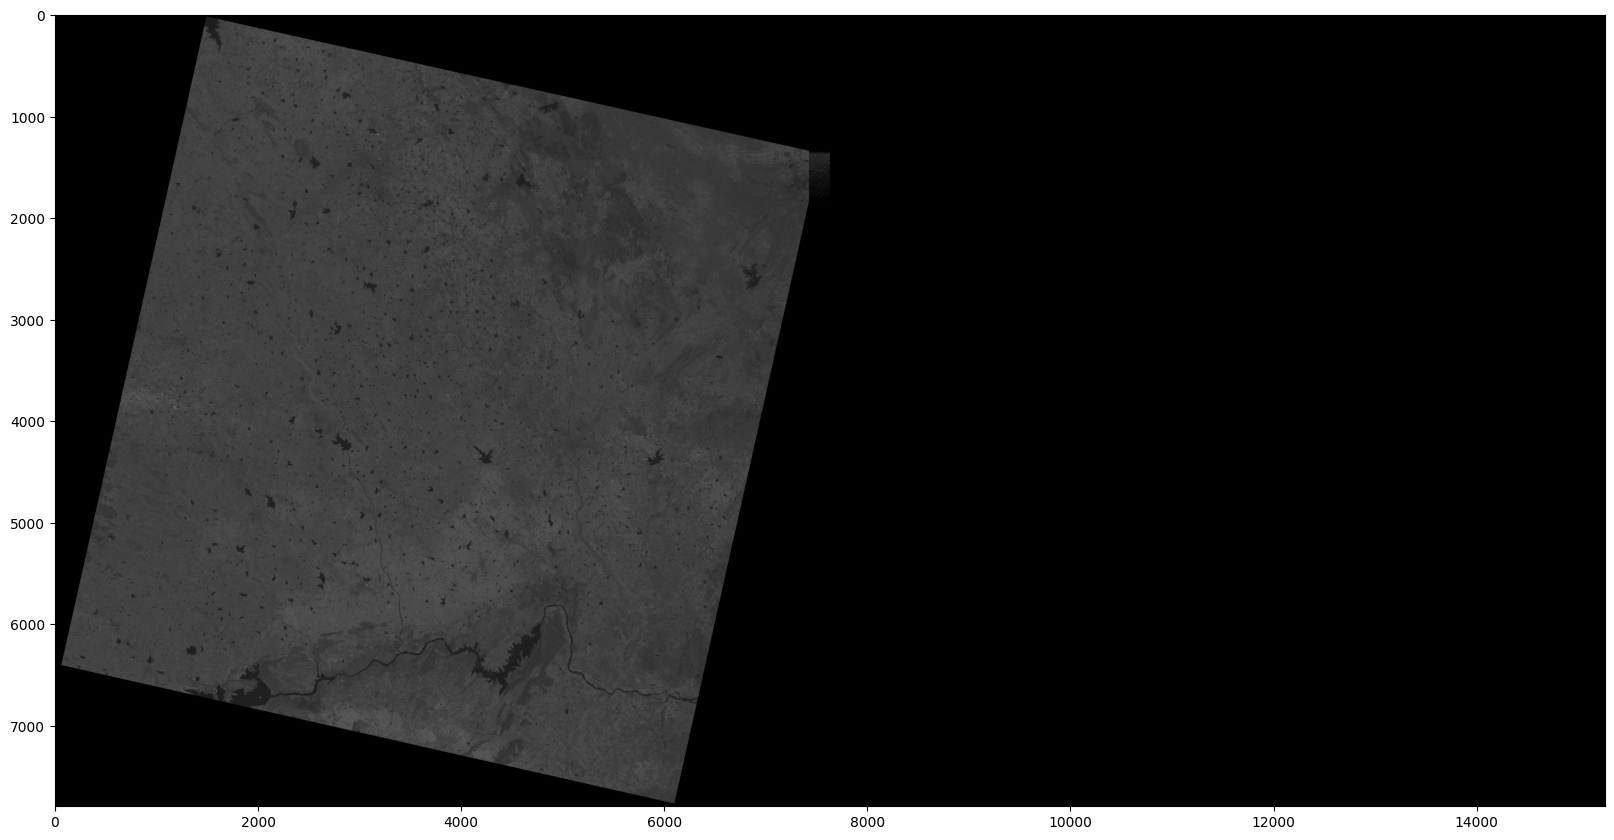

In [32]:
# For the calculation of the width and height of the final horizontal panoramic images
# I can just add the widths of the individual images and for the height
# I can take the max from the 2 individual images.

width = query_photo.shape[1] + train_photo.shape[1]
print("width ", width)
# 2922 - Which is exactly the sum value of the width of
# my train.jpg and query.jpg


height = max(query_photo.shape[0], train_photo.shape[0])

# otherwise, apply a perspective warp to stitch the images together

# Now just plug that "Homography_Matrix"  into cv::warpedPerspective and I shall have a warped image1 into image2 frame

result = cv2.warpPerspective(train_photo, Homography_Matrix,  (width, height))

# The warpPerspective() function returns an image or video whose size is the same as the size of the original image or video. Hence set the pixels as per my query_photo

result[0:query_photo.shape[0], 0:query_photo.shape[1]] = query_photo

plt.figure(figsize=(20,20))
plt.axis('on')
plt.imshow(result)

 

plt.show()